# Defect WSe2 Example

In this example, we are going to
1. Analyze a dataset (to set up the scale-shift layers)
2. Train a model
3. Use the model to infer on a structure.

Some caveats:
- The dataset is provided in this directory and consists of one training structure and one validation structure. The limited data means the final model won't be good, but it will train quickly and you will be able to learn how to use the code.
- This example does *not* cover converting raw GPAW data into the format required for GEARS H. For that, please see the example provided in our companion data processing tool (which we keep separate so as to not have the heavy GPAW dependency in GEARS H). 
We are working on open sourcing that tool as well.
- Before following this example, please make sure you have installed GEARS H according to the instructions in the README.
- Finally, we have provided you with a configuration file for this example. For your own projects, we suggest starting from one of our template configs, which you can have written to your current directory using `gears_h template train` or `gears_h template train --annotated`.

## Analyzing the dataset

The even-parity $\ell=0$ ($\ell = 0_+$) scalars in the irreducible representations (irreps) of the Hamiltonian can take on values up from -$\mathcal{O}(100)$ eV to $\mathcal{O}(100)$ eV.
This presents a challenge for the readout layers, which not only have to be able to span that large range of values but also be able to predict the much smaller $\ell > 0$ irreps.

To lighten the load on the readout layers and improve model accuracy, we have introduced scale-shift layers, which are non-learnable layers that scale and shift the $\ell = 0_+$ outputs of the readout layers such that they are approximately zero-centered and approximately unit variance.

For the off-diagonal scale-shift layers, the scale and shift is distance dependent and has the functional form $s = A \exp(- (d / d_0) ^ \alpha)$.
$A$, $d_0$, and $\alpha$ are referred to as the `exp_prefactors`, `exp_lengthscales`, and `exp_powers` in the scale-shift layer code, respectively.
They are added to the $\ell = 0_+$ irreps.

The on-diagonal scale shift layer is simpler and are applied to the $\ell = 0_+$ irreps by multiplying them by the scale value and then adding the shift value.

The analysis command is
```console
gears_h analyze dataset path/to/dataset/root N
```
where `N` is the number of structures to use in the analysis.
The resulting scale and shift parameters are averaged across the `N` structures used.

To analyze the training and validation sets, we can run the following commands:

In [1]:
!gears_h analyze dataset training_data/ 1

INFO | 14:28:12 | Reading datalist
INFO | 14:28:12 | Using 1 snapshots.
Reading dataset: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]
INFO | 14:28:12 | Orbital ells dictionary: {74: [0, 2, 1], 34: [0, 1, 2]}
INFO | 14:28:12 | Max ell: 4, max nfeatures: 4
INFO | 14:28:12 | Preparing inputs and labels.
Making on-diagonal irreps masks: 100%|█████████████████████████████| 1/1 [00:00<00:00, 11037.64it/s]
INFO | 14:28:13 | Analyzing off-diagonal elements.
INFO | 14:28:17 | Analyzing on-diagonal elements.
INFO | 14:28:17 | Analysis complete! View output in /home/ali/software/slh-dev/examples/WSe2-x/training_data/analysis


In [2]:
!gears_h analyze dataset validation_data/ 1

INFO | 14:28:29 | Reading datalist
INFO | 14:28:29 | Using 1 snapshots.
Reading dataset: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]
INFO | 14:28:29 | Orbital ells dictionary: {74: [0, 2, 1], 34: [0, 1, 2]}
INFO | 14:28:29 | Max ell: 4, max nfeatures: 4
INFO | 14:28:29 | Preparing inputs and labels.
Making on-diagonal irreps masks: 100%|█████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]
INFO | 14:28:29 | Analyzing off-diagonal elements.
INFO | 14:28:34 | Analyzing on-diagonal elements.
INFO | 14:28:34 | Analysis complete! View output in /home/ali/software/slh-dev/examples/WSe2-x/validation_data/analysis


These commands create folders name `analysis/` in the dataset root directory that contain three files:
- `analysis.log`
- `off_diag_analysis_results.yaml`
- `on_diag_analysis_results.yaml`

The `analysis.log` file is contains the log of the analysis, which is what was printed to the terminal above.

The `off_diag_analysis_results.yaml` file contains the parameters extracted for the off-diagonal, distance-dependent function used to scale and shift the irreps.
```yaml
34 34:
  exp_lengthscales:
  - 2.443323363985292
  - 3.1822743333222947
  - 1.0
  - 4.328927618132272
  exp_powers:
  - 3.1229404353520422
  - 2.4915754053617687
  - 0.0
  - 3.587930675226907
  exp_prefactors:
  - -5.458827405689627
  - 2.15364531454542
  - 2.718281828459045
  - -0.178644549851086
34 74:
  exp_lengthscales:
  - 2.39793516864026
  - 4.961612288391814
  - 1.0
  - 2.2360158215126322
  exp_powers:
  - 2.200823310846219
  - 13.556624563562414
  - 0.0
  - 3.488997935842146
  exp_prefactors:
  - -15.228942500334735
  - 0.2006624993390025
  - 2.718281828459045
  - 1.6180919080759757
74 34:
  exp_lengthscales:
  - 2.2924646862019378
  - 1.0
  - 2.42238633764235
  - 4.839175422579465
  exp_powers:
  - 2.085905275928274
  - 0.0
  - 3.6089996403603175
  - 9.2689876317963
  exp_prefactors:
  - -16.67092027236722
  - 2.718281828459045
  - 1.1014976511560834
  - 0.22362505215605663
74 74:
  exp_lengthscales:
  - 4.450349559524154
  - 1.0
  - 0.5
  - 0.5
  exp_powers:
  - 3.5239037468007623
  - 0.0
  - 1.0
  - 1.0
  exp_prefactors:
  - -1.9836927075714847
  - 2.718281828459045
  - -4.183306814212647e-09
  - -5.00034715380389e-09
```

The top level values are the atomic numbers for each pair, and the keys include the fit parameters for each feature of the model.
Since this model has 4 features (as shown in the log), there are 4 fits for each pair of atoms.
Note that the number of features a model will have is determined automatically and will depend on the angular momenta of the species in the system. 

Similarly, the `on_diag_analysis_results.yaml` file contains the scale and shift parameters for the on-diagonal irreps.
```yaml
34:
  scales:
  - 0.1653394841721676
  - 0.25580304411758775
  - 0.0
  - 0.43944795359407035
  shifts:
  - -17.45858517499037
  - -13.015181272802218
  - 0.0
  - 33.97192812637544
74:
  scales:
  - 0.30056340327266573
  - 0.0
  - 0.28216889224930414
  - 0.2362118876431558
  shifts:
  - -11.896353907055325
  - 0.0
  - -13.969017770555284
  - 11.121121406555176
```

When we train our model, the model will automatically read in the analysis parameters to initialize the scale-shift layers.

## Model training

We are now ready to train our model. We can do so by running the following command (adjust the CUDA device ID and NUMA node as needed for your machine):

In [3]:
!CUDA_VISIBLE_DEVICES=7 numactl -N 7 -l gears_h train config_full.yaml

INFO | 14:28:45 | Running on [CudaDevice(id=0)]
INFO | 14:28:45 | Initializing Callbacks
INFO | 14:28:45 | Using 1 snapshots.
Reading dataset: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]
INFO | 14:28:45 | Using 1 snapshots.
Reading dataset: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]
INFO | 14:28:46 | Train dataset information:
INFO | 14:28:46 | 	Max natoms: 107
INFO | 14:28:46 | 	Max bond-centered neighbours: 5378
INFO | 14:28:46 | 	Max atom-centered neighbours: 6132
INFO | 14:28:46 | Validation dataset information:
INFO | 14:28:46 | 	Max natoms: 107
INFO | 14:28:46 | 	Max bond-centered neighbours: 5392
INFO | 14:28:46 | 	Max atom-centered neighbours: 6180
INFO | 14:28:46 | Orbital ells dictionary: {74: [0, 2, 1], 34: [0, 1, 2]}
INFO | 14:28:46 | Max ell: 4, max nfeatures: 4
Making on-diagonal irreps masks: 100%|█████████████████████████████| 1/1 [00:00<00:00, 10922.67it/s]
INFO | 14:28:46 | Orbital ells d

The model is written out to `directory/experiment`, where `directory` and `experiment` are provided in the config file.
For the example, your model should be written to `models/wse2_example`.
In this directory, you'll find the latest checkpoints and the best checkpoint, as well as `log.csv` which contains the epochs, time, losses, MAEs, and learning rate over the course of the training. 
These can be plotted to see how the training has proceeded:

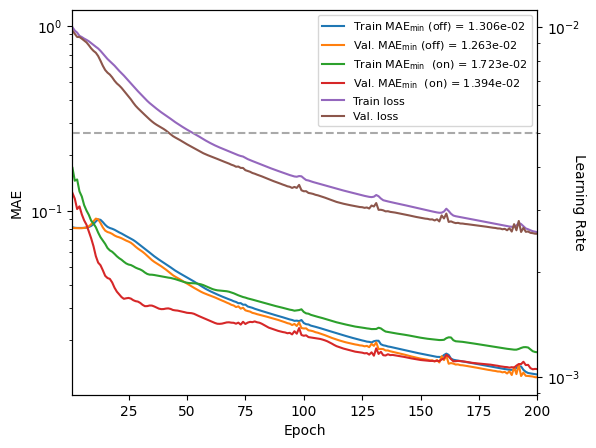

In [4]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

def plot_mae_loss(path: Path | str):
    log = np.loadtxt(path,delimiter=',', skiprows=1).transpose()

    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.plot(log[0]+1, log[3], label=rf"Train MAE$_\mathrm{{min}}$ (off) = {log[3].min():.03e}")
    ax.plot(log[0]+1, log[7], label=rf"Val. MAE$_\mathrm{{min}}$ (off) = {log[7].min():.03e}")
    
    ax.plot(log[0]+1, log[4], label=rf"Train MAE$_\mathrm{{min}}$  (on) = {log[4].min():.03e}")
    ax.plot(log[0]+1, log[8], label=rf"Val. MAE$_\mathrm{{min}}$  (on) = {log[8].min():.03e}")

    ax.plot(log[0]+1, log[2], label=r"Train loss")
    ax.plot(log[0]+1, log[6], label=r"Val. loss")

    plt.legend(fontsize=8)
    
    if log.shape[0] == 11:
        twax = ax.twinx()
        twax.plot(log[0]+1, log[10], color = 'darkgrey', ls='--')
        twax.semilogy()
        twax.set_ylabel("Learning Rate", rotation=270)
    
    ax.semilogy()
    ax.set_xlim(1,log[0].max()+1)
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MAE")

    return fig, ax, twax

fig, ax, twax = plot_mae_loss("models/wse2_example/log.csv")

For this example model, we see that the learning rate (LR) remains constant through the entire training process.
This is because the LR scheduler we are using is the `reduce_on_plateau` scheduler.
Since the loss never flattens, the LR never goes down.

We can also see the MAE of the on- and off-diagonal irreps for both the training and validation sets are going down smoothly.

## Inference

We are now ready to infer using our model.
We will be inferring on the validation structure (which you will likely want to do to understand your errors before applying your model to production systems).
The command to infer is
```console
gears_h infer path/to/model path/to/structure
```
Note that the structure file needs to be readable by `ase`.

In [5]:
!gears_h infer models/wse2_example/ validation_data/180_wse2_postopt/atoms.extxyz

INFO | 14:37:03 | Initializing model
INFO | 14:37:03 | Building model with analysis
INFO | 14:37:04 | Loading model parameters
INFO | 14:37:04 | loading checkpoint from /home/ali/software/slh-dev/examples/WSe2-x/models/wse2_example/best
INFO | 14:37:04 | Reading target structure.
INFO | 14:37:05 | Inferring H irreps.
INFO | 14:37:20 | Converting irreps to H-blocks.
INFO | 14:37:22 | Assembling H matrix.
INFO | 14:37:23 | Inference complete! You can now read in the inferred Hamiltonian with the following command:
INFO | 14:37:23 | infH = np.array(np.load('validation_data/180_wse2_postopt/inferred_H.npz', allow_pickle=True)['H_MM'][None][0])


The inferred structure is written out into the same directory that the structure file is in.
A log file (containing what you see in the stdout) is written in the directory in which you ran the inference command.

The log helpfully tells you how to read in your inferred Hamiltonian in the last line of the output.

Let's look at the reference and inferred Hamiltonians, as well as the error.

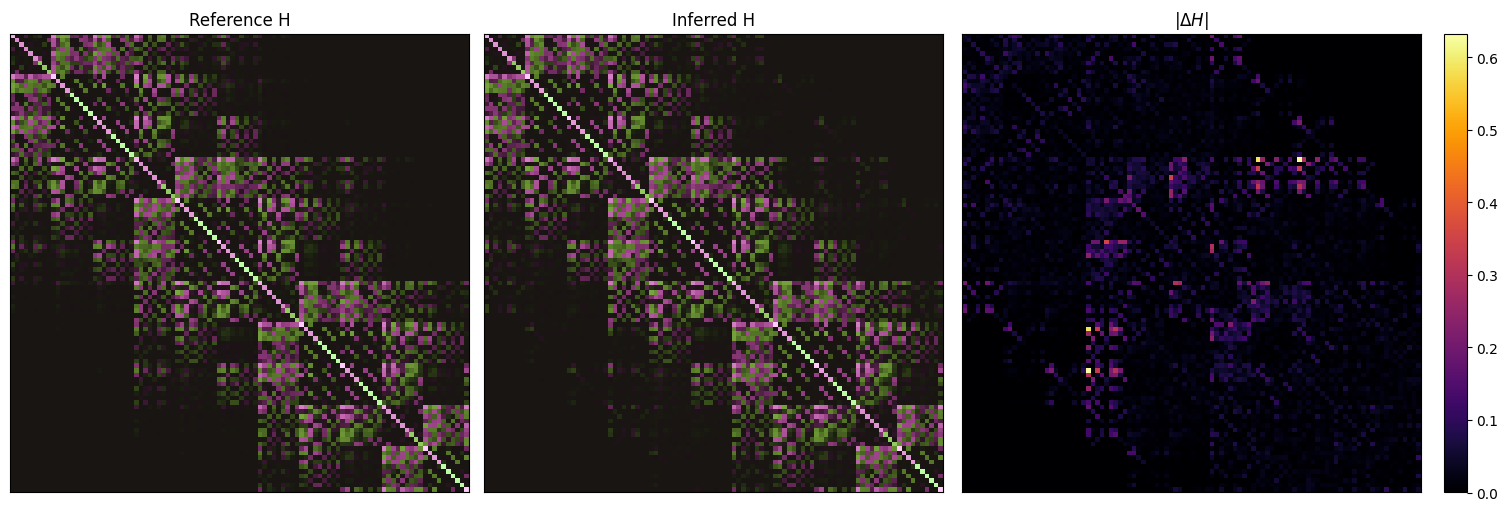

In [6]:
from matplotlib.colors import AsinhNorm
import numpy as np

reference_H = np.load('validation_data/180_wse2_postopt/H_MM_S_MM.npz', allow_pickle=True)['H_MM'][None][0].toarray()
inf_H = np.array(np.load('validation_data/180_wse2_postopt/inferred_H.npz', allow_pickle=True)['H_MM'][None][0])

fig, axes = plt.subplots(1,3,figsize=(15,5), layout='constrained')

subset = 100
axes[0].matshow(reference_H[:subset,:subset], cmap=plt.cm.vanimo, norm=AsinhNorm(linear_width=0.1))
axes[0].set_title("Reference H")
axes[1].matshow(inf_H[:subset,:subset], cmap=plt.cm.vanimo, norm=AsinhNorm(linear_width=0.1))
axes[1].set_title("Inferred H")
errors = axes[2].matshow(np.abs(inf_H - reference_H)[:subset,:subset], cmap=plt.cm.inferno)#, norm=AsinhNorm(linear_width=0.1))
fig.colorbar(errors,ax=axes[2], shrink=1)
axes[2].set_title(r"$|\Delta H|$")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

We are looking at a small subset of the Hamiltonians for visualization purposes. 
Note that we have an `asinh` scale with `linear_width=0.1` on the reference and inferred Hamiltonians so that we can see the off diagonal components better.

For a model trained on a single structure for only 200 epochs, the errors are quite good!